In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install --upgrade pandas==1.3.1
!pip install keras

In [ ]:
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers import Dense, LSTM, Flatten, Embedding
from tensorflow.keras.utils import to_categorical
from keras.backend import clear_session

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import multiprocessing
import seaborn as sns
import email
import matplotlib.pyplot as plt

In [ ]:
filename = "/content/drive/MyDrive/ColabTest/GoogleNews-vectors-negative300.bin"

start = time.time()
google_embeddings = KeyedVectors.load_word2vec_format(filename, binary=True)

print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  62.40432047843933


In [ ]:
# load Stanford's pre-trained GloVe embeddings
glove_file = "/content/drive/MyDrive/ColabTest/glove.6B.300d.txt"
glove_word2vec_file = "glove.6B.100d.txt.word2vec"

glove2word2vec(glove_file, glove_word2vec_file)

(400000, 300)

In [ ]:
data = pd.read_pickle("/content/drive/MyDrive/ColabTest/enron_dataframe.pkl")


In [ ]:
data.head()

,Text,Person
0,,arnold-j
1,let's push until monday,arnold-j
2,what's pdx?,arnold-j
3,"BMO wants to do this sleave trade. Duke, Dyneg...",arnold-j
4,I'm big seller of interventions. they tend not...,arnold-j


In [ ]:
data.shape

(95573, 2)

In [ ]:
data['Person'].unique()

array(['arnold-j', 'phanis-s', 'lavorato-j', 'stclair-c', 'townsend-j',
       'forney-j', 'symes-k', 'reitmeyer-j', 'hyatt-k', 'steffes-j',
       'kaminski-v', 'wolfe-j', 'mcconnell-m', 'skilling-j', 'zipper-a',
       'shively-h', 'donoho-l', 'sanchez-m', 'delainey-d', 'germany-c',
       'whalley-l', 'buy-r', 'tholt-j', 'cash-m', 'sanders-r', 'staab-t',
       'semperger-c', 'mccarty-d', 'mclaughlin-e', 'ring-a', 'weldon-c',
       'ring-r', 'farmer-d', 'sager-e', 'zufferli-j', 'ybarbo-p',
       'watson-k', 'dasovich-j', 'arora-h', 'slinger-r', 'martin-t',
       'storey-g', 'ruscitti-k', 'shankman-j', 'schwieger-j',
       'perlingiere-d', 'saibi-e', 'griffith-j', 'meyers-a', 'grigsby-m',
       'taylor-m', 'rapp-b', 'causholli-m', 'derrick-j', 'bass-e',
       'south-s', 'salisbury-h', 'beck-s', 'tycholiz-b', 'shackleton-s',
       'kitchen-l', 'blair-l', 'quenet-j', 'lokey-t', 'williams-j',
       'panus-s', 'gang-l', 'hendrickson-s', 'schoolcraft-d', 'mann-k',
       'kuykenda

In [ ]:
def label_encoder(data):
    class_le = LabelEncoder()
    # apply label encoder on the 'X-Folder' column
    y = class_le.fit_transform(data['Person'])
    return y

In [ ]:
y = label_encoder(data)
input_data = data['Text']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_data, y, test_size=0.1)

In [ ]:
# one-hot encode the output labels
Y_train = to_categorical(y_train, 144)
Y_test = to_categorical(y_test, 144)

In [ ]:
# prepare tokenizer
t = Tokenizer()

# fit the tokenizer on the docs
t.fit_on_texts(input_data)
vocab_size = len(t.word_index) + 1

# integer encode the documents
X_train_encoded_docs = t.texts_to_sequences(X_train)
X_test_encoded_docs = t.texts_to_sequences(X_test)

In [ ]:
# pad documents to a max length of 150 words
max_length = 150
X_train_padded_docs = pad_sequences(X_train_encoded_docs, maxlen=max_length, padding='post')
X_test_padded_docs = pad_sequences(X_test_encoded_docs, maxlen=max_length, padding='post')

print(X_train_padded_docs[0])

[   30     1   358     8  1285 20800     6    28  2087    60   634   359
     8   671  1492   114    18    46   787    22    27     9   122    43
  1849   489  4902   111  9420  2690   570   600    12     1   781   165
   334     8    45   182    27     9    20    55   252    42   177    43
    80    93  2109   930   643    30    67  1152 92734     6    23    19
    13   807     1  1237     8    17   146     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = google_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [ ]:
# define the model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(100, dropout=0.2))
model.add(Flatten())
model.add(Dense(144, activation='softmax'))


# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          32920200  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 144)               14544     
                                                                 
Total params: 33,095,144
Trainable params: 174,944
Non-trainable params: 32,920,200
_________________________________________________________________


In [ ]:
clear_session()

In [ ]:
# train the model
clear_session()
history = model.fit(X_train_padded_docs, Y_train, epochs=30, verbose=1, validation_split=0.1)

In [ ]:
# evaluate the model on the test set
accr = model.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr[0], accr[1]))

In [ ]:
# plot the loss
plt.title("Word2Vec Loss")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
# plot the accuracy
plt.title("Word2Vec Accuracy")
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = glove_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [ ]:
# define the model
model2 = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model2.add(e)
model2.add(LSTM(100, dropout=0.2))
model2.add(Flatten())
model2.add(Dense(144, activation='softmax'))


# compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          32920200  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 144)               14544     
                                                                 
Total params: 33,095,144
Trainable params: 174,944
Non-trainable params: 32,920,200
_________________________________________________________________


In [ ]:
# fit the model
history2 = model2.fit(X_train_padded_docs, Y_train, epochs=30, verbose=1, validation_split=0.1)

Epoch 1/30
2420/2420 [==============================] - 520s 214ms/step - loss: 3.9876 - accuracy: 0.1108 - val_loss: 3.5104 - val_accuracy: 0.2246
Epoch 2/30
2420/2420 [==============================] - 516s 213ms/step - loss: 3.1756 - accuracy: 0.2912 - val_loss: 2.8436 - val_accuracy: 0.3651
Epoch 3/30
2420/2420 [==============================] - 515s 213ms/step - loss: 2.7454 - accuracy: 0.3898 - val_loss: 2.5583 - val_accuracy: 0.4348
Epoch 4/30
2420/2420 [==============================] - 515s 213ms/step - loss: 2.5241 - accuracy: 0.4427 - val_loss: 2.3934 - val_accuracy: 0.4781
Epoch 5/30
2420/2420 [==============================] - 515s 213ms/step - loss: 2.3588 - accuracy: 0.4793 - val_loss: 2.2857 - val_accuracy: 0.4983
Epoch 6/30
2420/2420 [==============================] - 517s 214ms/step - loss: 2.2608 - accuracy: 0.5011 - val_loss: 2.2298 - val_accuracy: 0.5106
Epoch 7/30
2420/2420 [==============================] - 517s 214ms/step - loss: 2.1571 - accuracy: 0.5205 - val_

In [ ]:
# evaluate the model2 on the test set
accr2 = model2.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr2[0], accr2[1]))

299/299 [==============================] - 21s 69ms/step - loss: 1.8167 - accuracy: 0.6072
Test Set: 
 Loss: 1.817
 Accuracy: 0.607


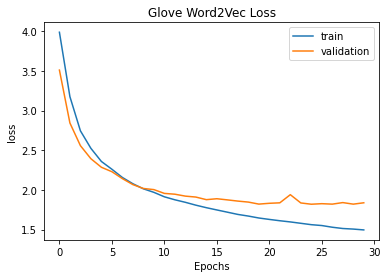

In [ ]:
# plot the loss
plt.title("Glove Word2Vec Loss")
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

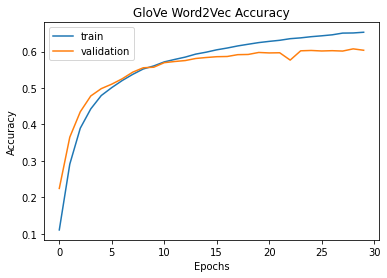

In [ ]:
# plot the accuracy
plt.title("GloVe Word2Vec Accuracy")
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()